In [1]:
import re
import tensorflow as tf
from tensorflow import keras
from keras import layers
from pathlib import Path
from dataclasses import dataclass, field, replace, asdict
from typing import List, Optional
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
from IPython.display import display


@dataclass
class DataConfig:
    data_dir: str = "data/breakhis-dataset/binary/40X" # based on the best peforming magnification
    img_size: int = 224
    batch_size: int = 32
    validation_split: float = 0.2
    seed: int = 123


@dataclass
class ModelConfig:
    backbone: str = "EfficientNetB0"
    pretrained: bool = True
    unfreeze_blocks: int = 1
    blocks_to_unfreeze: Optional[List[int]] = None
    dropout_rate: float = 0.2


@dataclass
class TrainingConfig:
    epochs: int = 10
    learning_rate: float = 1e-4
    optimizer: str = "Adam"
    loss: str = "binary_crossentropy"
    metrics: List[str] = field(default_factory=lambda: ["accuracy"])


@dataclass
class CallbackConfig:
    tensorboard_logdir: str = "logs/"
    checkpoint_dir: str = "checkpoints/"
    model_save_dir: str = "saved_models/"
    save_model: bool = False


@dataclass
class ExperimentConfig:
    data: DataConfig = field(default_factory=DataConfig)
    model: ModelConfig = field(default_factory=ModelConfig)
    training: TrainingConfig = field(default_factory=TrainingConfig)
    callbacks: CallbackConfig = field(default_factory=CallbackConfig)


def print_block(title: str, data: dict):
    labels = {
        k: (f"{v:.2f}" if isinstance(v, float) else str(v)) for k, v in data.items()
    }
    lbl_w = max(len(k) for k in labels)
    val_w = max(len(v) for v in labels.values())
    total_w = lbl_w + 2 + val_w + 2
    title_str = f" {title} "
    border = "=" * max(len(title_str), total_w)
    print(f"\n{border}")
    print(title_str.center(len(border)))
    print(border)
    for k, v in labels.items():
        print(f"{k.ljust(lbl_w)} : {v.rjust(val_w)}")
    print(border + "\n")


def summarize_model(base):
    block_layers = {}
    block_trainable = {}
    for layer in base.layers:
        m = re.match(r"^block(\d+)[a-z]?_", layer.name)
        blk = int(m.group(1)) if m else 0
        block_layers[blk] = block_layers.get(blk, 0) + 1
        block_trainable[blk] = block_trainable.get(blk, False) or layer.trainable
    rows = []
    for blk in sorted(block_layers):
        name = f"block{blk}" if blk > 0 else "stem/head"
        rows.append(
            (name, str(block_layers[blk]), "Yes" if block_trainable[blk] else "No")
        )
    headers = ("Block", "Layers", "Trainable")
    col1 = max(len(r[0]) for r in rows + [headers])
    col2 = max(len(r[1]) for r in rows + [headers])
    col3 = max(len(r[2]) for r in rows + [headers])
    total_w = col1 + col2 + col3 + 6
    border = "=" * total_w
    print(f"\n{border}")
    print(
        f"{headers[0].ljust(col1)} | {headers[1].rjust(col2)} | {headers[2].rjust(col3)}"
    )
    print(border)
    for name, cnt, tf in rows:
        print(f"{name.ljust(col1)} | {cnt.rjust(col2)} | {tf.rjust(col3)}")
    print(border + "\n")


def prepare_dataset(cfg: ExperimentConfig):
    dc = cfg.data
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dc.data_dir,
        labels="inferred",
        label_mode="binary",
        batch_size=dc.batch_size,
        image_size=(dc.img_size, dc.img_size),
        validation_split=dc.validation_split,
        subset="training",
        seed=dc.seed,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dc.data_dir,
        labels="inferred",
        label_mode="binary",
        batch_size=dc.batch_size,
        image_size=(dc.img_size, dc.img_size),
        validation_split=dc.validation_split,
        subset="validation",
        seed=dc.seed,
    )
    return train_ds.prefetch(tf.data.AUTOTUNE), val_ds.prefetch(tf.data.AUTOTUNE)


def build_model(cfg: ExperimentConfig):
    mc = cfg.model
    img_size = cfg.data.img_size
    base = getattr(keras.applications, mc.backbone)(
        include_top=False,
        weights="imagenet" if mc.pretrained else None,
        input_shape=(img_size, img_size, 3),
    )
    block_nums = {
        int(m.group(1))
        for layer in base.layers
        if (m := re.match(r"^block(\d+)[a-z]?_", layer.name))
    }
    unique_blocks = sorted(block_nums)
    if mc.blocks_to_unfreeze:
        target_blocks = mc.blocks_to_unfreeze
    else:
        target_blocks = unique_blocks[-mc.unfreeze_blocks :]
    for layer in base.layers:
        m = re.match(r"^block(\d+)[a-z]?_", layer.name)
        freeze = not (
            m
            and int(m.group(1)) in target_blocks
            and not isinstance(layer, layers.BatchNormalization)
        )
        layer.trainable = not freeze
    inp = keras.Input((img_size, img_size, 3))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(mc.dropout_rate)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    return model, base


def compile_and_train(model: keras.Model, train_ds, val_ds, cfg: ExperimentConfig):
    tc = cfg.training
    cb = cfg.callbacks
    opt = getattr(keras.optimizers, tc.optimizer)(learning_rate=tc.learning_rate)
    model.compile(optimizer=opt, loss=tc.loss, metrics=tc.metrics)
    callbacks = []
    if cb.tensorboard_logdir:
        callbacks.append(keras.callbacks.TensorBoard(log_dir=cb.tensorboard_logdir))
    if cb.checkpoint_dir:
        p = Path(cb.checkpoint_dir)
        p.mkdir(parents=True, exist_ok=True)
        callbacks.append(
            keras.callbacks.ModelCheckpoint(
                filepath=str(p / "ckpt_{epoch}.keras"),
                save_best_only=True,
                monitor="val_loss",
            )
        )
    return model.fit(
        train_ds, validation_data=val_ds, epochs=tc.epochs, callbacks=callbacks
    )


def plot_history(history):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)
    plt.figure()
    plt.plot(epochs, hist["loss"], label="Training Loss")
    plt.plot(epochs, hist["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    if "accuracy" in hist:
        plt.figure()
        plt.plot(epochs, hist["accuracy"], label="Training Accuracy")
        plt.plot(epochs, hist["val_accuracy"], label="Validation Accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()


def report_results(model: keras.Model, val_ds):
    try:
        y_true, y_pred = [], []
        for x_batch, y_batch in val_ds.unbatch().batch(1024):
            preds = (model.predict(x_batch) > 0.5).astype(int).flatten()
            y_true.extend(y_batch.numpy().astype(int))
            y_pred.extend(preds.tolist())
        print("\nClassification Report:\n")
        print(classification_report(y_true, y_pred, digits=4))
    except Exception as e:
        print(f"\nCould not compute classification report: {e}")


def run_experiment(experiment_name: str = "experiment", **overrides):
    cfg = ExperimentConfig()
    for section, params in overrides.items():
        if hasattr(cfg, section) and isinstance(params, dict):
            old = getattr(cfg, section)
            new = replace(old, **params)
            cfg = replace(cfg, **{section: new})
        else:
            raise ValueError(f'Unknown section "{section}" or invalid params')
    cfg_dict = {}
    flat = asdict(cfg)
    for sec, sec_vals in flat.items():
        for k, v in sec_vals.items():
            cfg_dict[f"{sec}.{k}"] = v
    print_block("Experiment Config", cfg_dict)
    train_ds, val_ds = prepare_dataset(cfg)
    model, base = build_model(cfg)
    summarize_model(base)
    history = compile_and_train(model, train_ds, val_ds, cfg)
    plot_history(history)
    report_results(model, val_ds)
    if cfg.callbacks.save_model:
        save_path = Path(cfg.callbacks.model_save_dir)
        save_path.mkdir(parents=True, exist_ok=True)
        model.save(save_path / f"{experiment_name}.keras")
    return {"history": history, "model": model}


PREFIX_MAP = [
    ("baseline", "Baseline"),
    ("block", "Blocks"),
    ("lr", "Learning Rate"),
    ("optimizer", "Optimizers"),
    ("dropout", "Dropouts"),
    ("batchsize", "Batch Sizes"),
    ("mag", "Magnification")
]


def categorize(key):
    for pfx, label in PREFIX_MAP:
        if key.startswith(pfx):
            return label
    return "Other"


def report_experiments(exp: dict, alpha: float = 0.6):
    rows = []
    for name, res in exp.items():
        hist = res["history"].history
        val_loss = hist["val_loss"]
        train_loss = hist["loss"]
        val_acc = hist.get("val_accuracy")
        best_idx = int(pd.Series(val_loss).idxmin())
        rows.append(
            {
                "Experiment": name,
                "Category": categorize(name),
                "Validation Accuracy": val_acc[best_idx],
                "Validation Loss": val_loss[best_idx],
                "Overfit Gap": val_loss[best_idx] - train_loss[best_idx],
            }
        )
    df = pd.DataFrame(rows)
    df["NormLoss"] = df.groupby("Category")["Validation Loss"].transform(
        lambda s: (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else 0.0
    )
    df["NormGap"] = df.groupby("Category")["Overfit Gap"].transform(
        lambda s: (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else 0.0
    )
    df["Score"] = (1 - alpha) * (1 - df["NormLoss"]) + alpha * (1 - df["NormGap"])
    display(df.drop(columns=["NormGap"]).round(4))
    best = df.loc[df["Score"].idxmax()]
    best_by_cat = (
        df.sort_values("Score", ascending=False)
        .groupby("Category", as_index=False)
        .first()[
            [
                "Category",
                "Experiment",
                "Validation Accuracy",
                "Validation Loss",
                "Overfit Gap",
            ]
        ]
    )
    display(best_by_cat.round(4))

2025-05-16 18:05:26.239393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747389926.300263   53193 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747389926.317736   53193 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747389926.451201   53193 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747389926.451236   53193 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747389926.451238   53193 computation_placer.cc:177] computation placer alr

In [2]:
exp = {}

## Magnifications
- Breakhis dataset offers a range of magnifiactions to use with ranges from 40X to 400X.
- Before conducting any subsequent experiments, experiments will be conducted on these magnifications to evaluate which has the best peformance that will be used across all experiments.


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

I0000 00:00:1747376594.426873     573 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:0b:00.0, compute capability: 7.5


Found 1995 files belonging to 2 classes.
Using 399 files for validation.

Block     | Layers | Trainable
stem/head |     11 |        No
block1    |     10 |        No
block2    |     29 |        No
block3    |     29 |        No
block4    |     44 |        No
block5    |     43 |        No
block6    |     59 |        No
block7    |     13 |       Yes

Epoch 1/10


I0000 00:00:1747376604.688440     657 service.cc:152] XLA service 0x7f712404e280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747376604.688470     657 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-05-16 14:23:24.949244: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747376606.093228     657 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/50 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3698 - loss: 0.7839  

I0000 00:00:1747376613.910790     657 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 363ms/step - accuracy: 0.6398 - loss: 0.6045 - val_accuracy: 0.8271 - val_loss: 0.4009
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8574 - loss: 0.3640 - val_accuracy: 0.9048 - val_loss: 0.2580
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8974 - loss: 0.2662 - val_accuracy: 0.9098 - val_loss: 0.2184
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9154 - loss: 0.2218 - val_accuracy: 0.9348 - val_loss: 0.1686
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9300 - loss: 0.1861 - val_accuracy: 0.9373 - val_loss: 0.1552
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9512 - loss: 0.1366 - val_accuracy: 0.9449 - val_loss: 0.1219
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9560 - loss: 0.1163 - val_accuracy: 0.9474 - val_loss: 0.1106
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9724 - loss: 0.0879 - val_accuracy: 0.9549 - val_loss: 

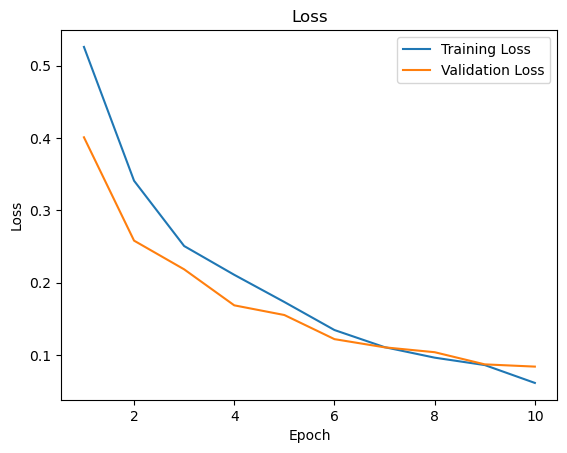

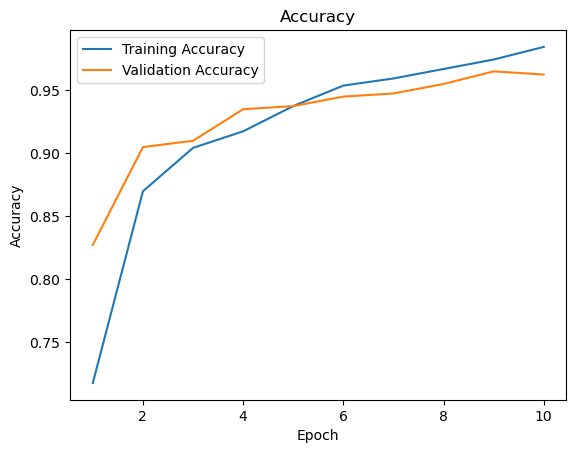

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9762    0.9111    0.9425       135
           1     0.9560    0.9886    0.9721       264

    accuracy                         0.9624       399
   macro avg     0.9661    0.9499    0.9573       399
weighted avg     0.9629    0.9624    0.9621       399



2025-05-16 14:24:20.901271: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



                        Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/100X
data.img_size                :                               224
data.batch_size              :                                32
data.validation_split        :                              0.20
data.seed                    :                               123
model.backbone               :                    EfficientNetB0
model.pretrained             :                              True
model.unfreeze_blocks        :                                 1
model.blocks_to_unfreeze     :                              None
model.dropout_rate           :                              0.20
training.epochs              :                                10
training.learning_rate       :                              0.00
training.optimizer           :                              Adam
training.loss                :               binary_crossentropy
training.metrics       

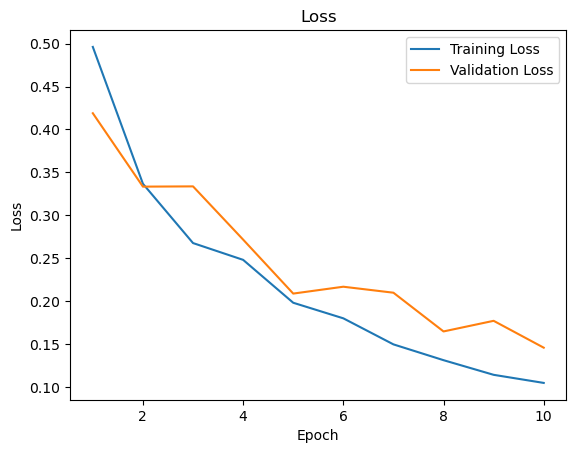

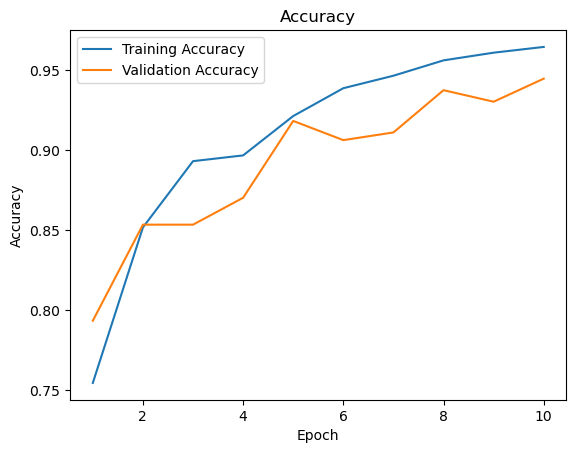

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9398    0.8929    0.9158       140
           1     0.9470    0.9710    0.9589       276

    accuracy                         0.9447       416
   macro avg     0.9434    0.9319    0.9373       416
weighted avg     0.9446    0.9447    0.9443       416



2025-05-16 14:25:16.654904: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



                        Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/200X
data.img_size                :                               224
data.batch_size              :                                32
data.validation_split        :                              0.20
data.seed                    :                               123
model.backbone               :                    EfficientNetB0
model.pretrained             :                              True
model.unfreeze_blocks        :                                 1
model.blocks_to_unfreeze     :                              None
model.dropout_rate           :                              0.20
training.epochs              :                                10
training.learning_rate       :                              0.00
training.optimizer           :                              Adam
training.loss                :               binary_crossentropy
training.metrics       

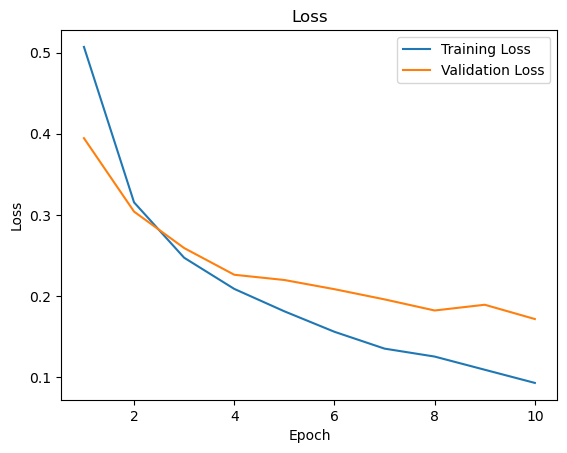

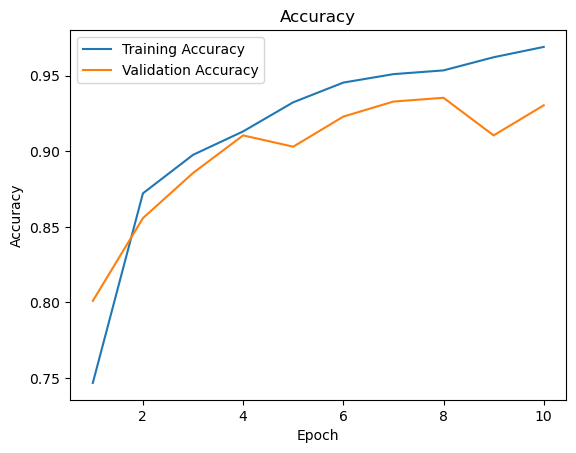

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.8849    0.9111    0.8978       135
           1     0.9544    0.9401    0.9472       267

    accuracy                         0.9303       402
   macro avg     0.9196    0.9256    0.9225       402
weighted avg     0.9310    0.9303    0.9306       402


                        Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/400X
data.img_size                :                               224
data.batch_size              :                                32
data.validation_split        :                              0.20
data.seed                    :                               123
model.backbone               :                    EfficientNetB0
model.pretrained             :                              True
model.unfreeze_blocks        :                                 1
model.blocks_to_unfr

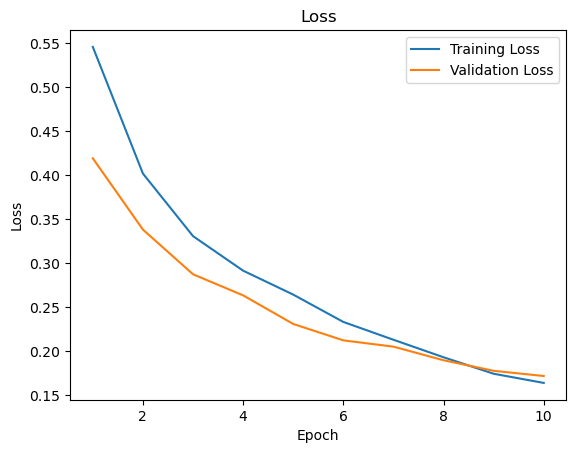

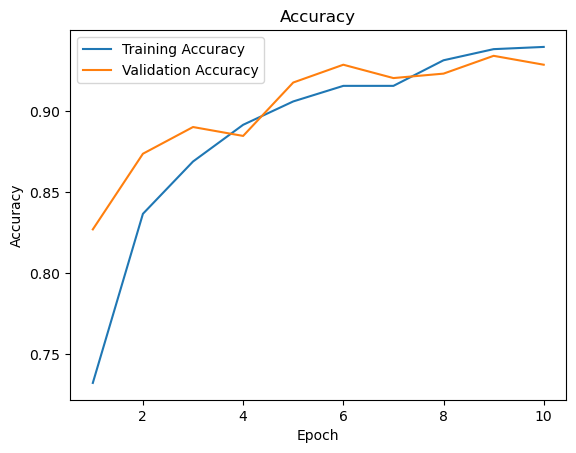

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9060    0.8760    0.8908       121
           1     0.9393    0.9547    0.9469       243

    accuracy                         0.9286       364
   macro avg     0.9226    0.9154    0.9188       364
weighted avg     0.9282    0.9286    0.9283       364



2025-05-16 14:27:23.869808: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
for mag in [40, 100, 200, 400]:
    exp[f"mag_{mag}"] = run_experiment(
        data={"data_dir": f"data/breakhis-dataset/binary/{mag}X"}, 
        callbacks={"save_model": True}
    )

In [4]:
report_experiments(exp)

,Experiment,Category,Validation Accuracy,Validation Loss,Overfit Gap,NormLoss,Score
0,mag_40,Magnification,0.9624,0.0839,0.0225,0.0000,0.8341
1,mag_100,Magnification,0.9447,0.1458,0.0410,0.7049,0.4842
2,mag_200,Magnification,0.9303,0.1718,0.0787,1.0000,0.0000
3,mag_400,Magnification,0.9286,0.1716,0.0079,0.9984,0.8003


,Category,Experiment,Validation Accuracy,Validation Loss,Overfit Gap
0,Magnification,mag_40,0.9624,0.0839,0.0225


## Baseline
This will be used for comparison


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

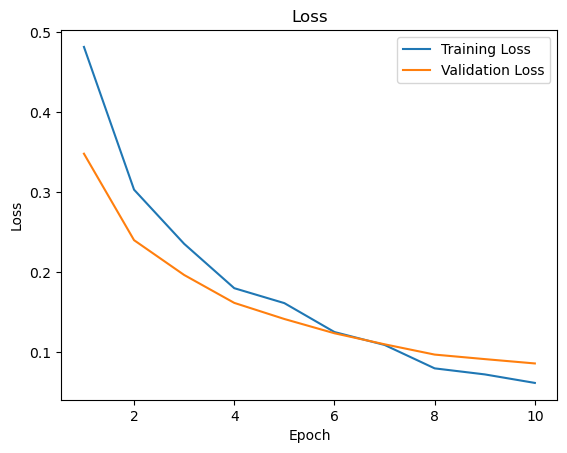

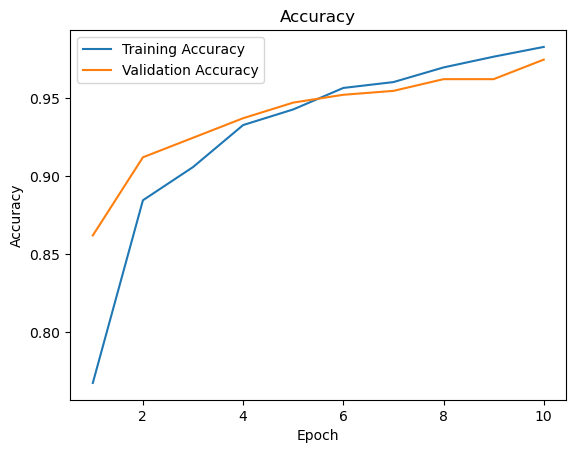

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9630    0.9630    0.9630       135
           1     0.9811    0.9811    0.9811       264

    accuracy                         0.9749       399
   macro avg     0.9720    0.9720    0.9720       399
weighted avg     0.9749    0.9749    0.9749       399



In [5]:
exp['baseline'] = run_experiment(experiment_name='baseline')

## Blocks
-  Earlier layers tend to learn very general features
-  Later blocks capture more specialized patterns

Fine-tune varying depths by testing it empirically to identify which one will work the best for our dataset.


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                6
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

2025-05-16 14:29:40.592693: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 14:29:40.798541: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 14:29:41.002691: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 14:29:42.139780: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 14:29:42.366195: E external/local_xla/xla/stream_

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7920 - loss: 0.4371

2025-05-16 14:30:02.671495: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 14:30:02.876863: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 14:30:04.008143: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 14:30:04.233222: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-16 14:30:04.503017: E external/local_xla/xla/stream_

50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 621ms/step - accuracy: 0.7944 - loss: 0.4330 - val_accuracy: 0.9323 - val_loss: 0.1707
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9369 - loss: 0.1565 - val_accuracy: 0.9674 - val_loss: 0.1285
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9735 - loss: 0.0760 - val_accuracy: 0.9850 - val_loss: 0.0387
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9960 - loss: 0.0231 - val_accuracy: 0.9799 - val_loss: 0.0402
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9940 - loss: 0.0214 - val_accuracy: 0.9925 - val_loss: 0.0341
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9828 - loss: 0.0400 - val_accuracy: 0.9825 - val_loss: 0.0548
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9910 - loss: 0.0262 - val_accuracy: 0.9900 - val_loss: 0.0227
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9997 - loss: 0.0057 - val_accuracy: 0.9950 - val_l

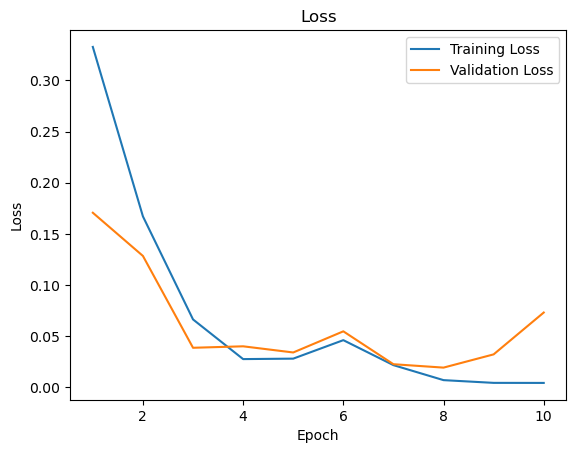

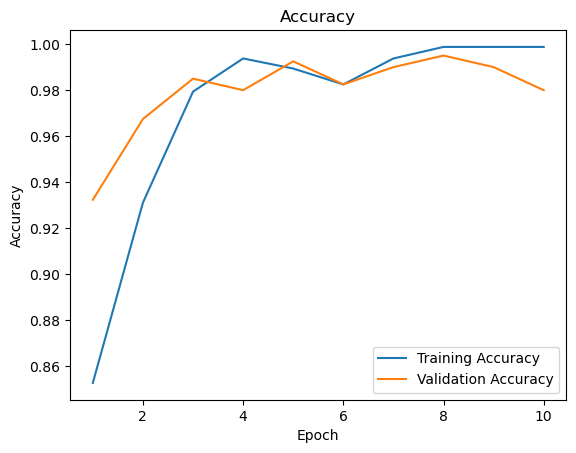

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9407    0.9695       135
           1     0.9706    1.0000    0.9851       264

    accuracy                         0.9799       399
   macro avg     0.9853    0.9704    0.9773       399
weighted avg     0.9805    0.9799    0.9798       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                5
model.blocks_to_unfreeze     

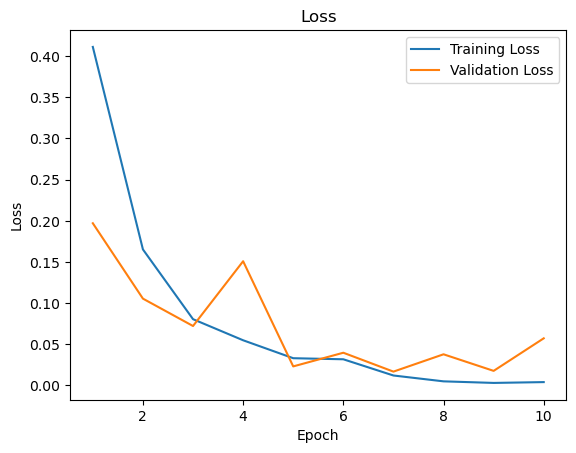

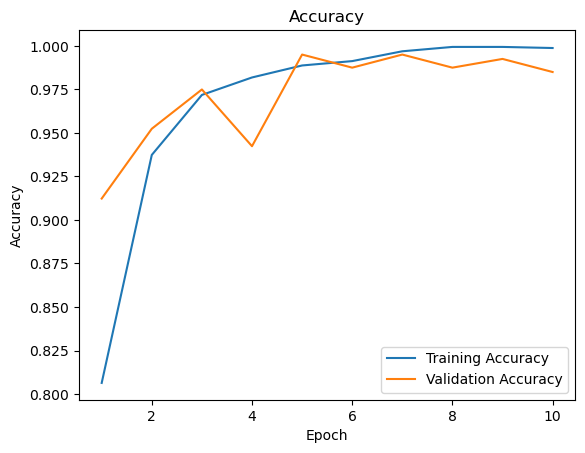

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9556    0.9773       135
           1     0.9778    1.0000    0.9888       264

    accuracy                         0.9850       399
   macro avg     0.9889    0.9778    0.9830       399
weighted avg     0.9853    0.9850    0.9849       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                4
model.blocks_to_unfreeze     

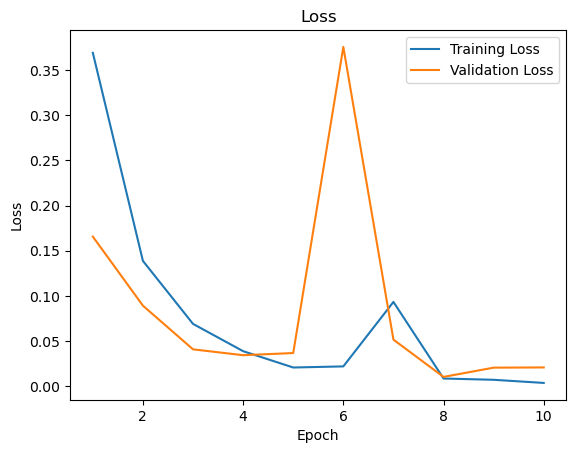

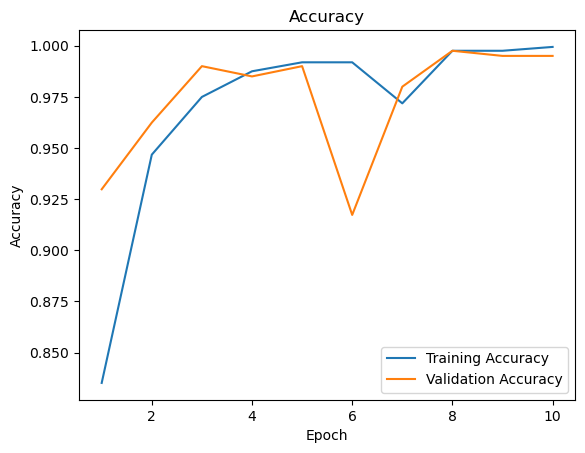

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9926    0.9926    0.9926       135
           1     0.9962    0.9962    0.9962       264

    accuracy                         0.9950       399
   macro avg     0.9944    0.9944    0.9944       399
weighted avg     0.9950    0.9950    0.9950       399



2025-05-16 14:34:10.743344: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
for b in [6, 5, 4]:
    exp[f'block_{b}'] = run_experiment(
        experiment_name=f'block_{b}',
        model={'unfreeze_blocks': b},
        callbacks={"save_model": True},
    )


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                3
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

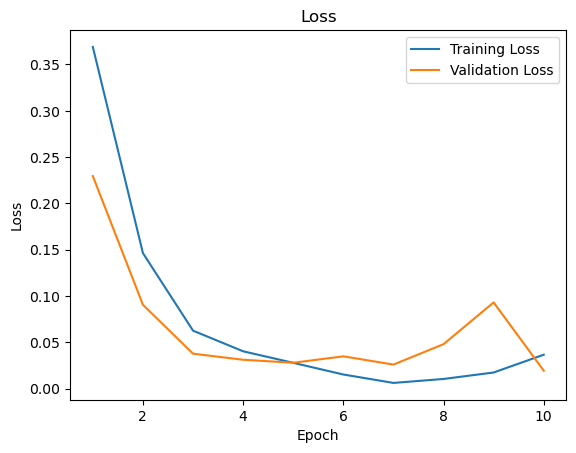

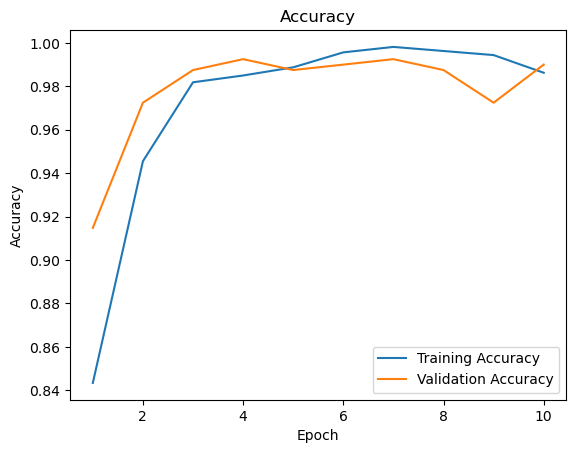

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9925    0.9778    0.9851       135
           1     0.9887    0.9962    0.9925       264

    accuracy                         0.9900       399
   macro avg     0.9906    0.9870    0.9888       399
weighted avg     0.9900    0.9900    0.9900       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                2
model.blocks_to_unfreeze     

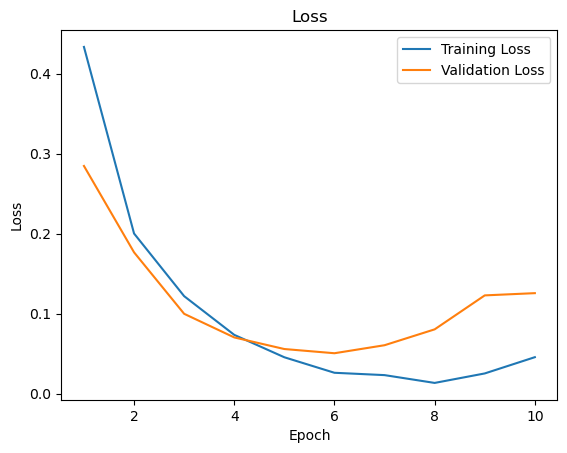

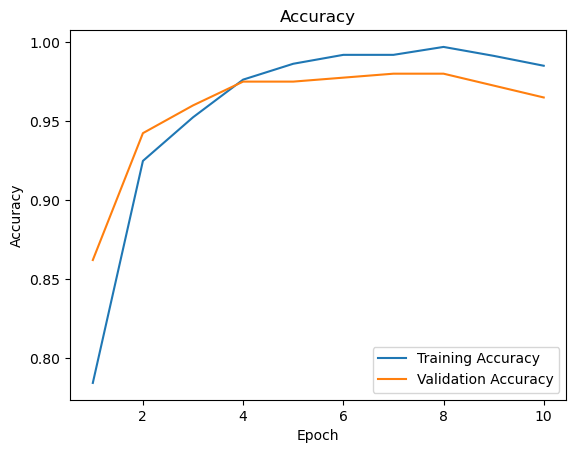

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.8963    0.9453       135
           1     0.9496    1.0000    0.9742       264

    accuracy                         0.9649       399
   macro avg     0.9748    0.9481    0.9597       399
weighted avg     0.9667    0.9649    0.9644       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

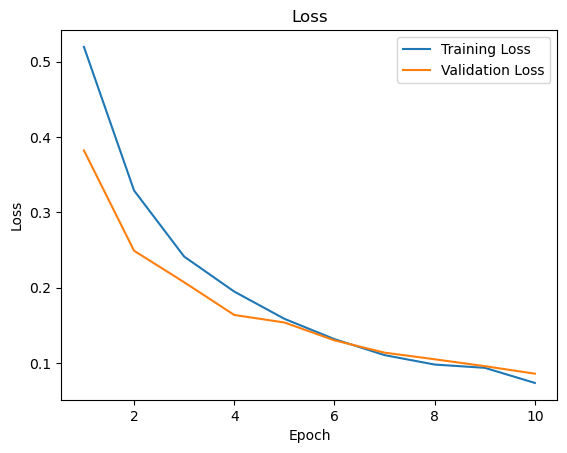

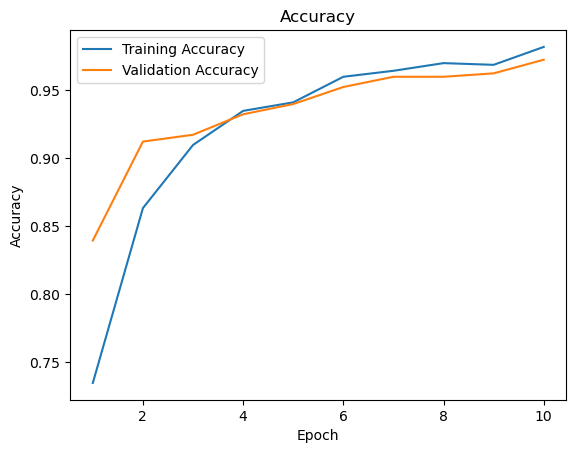

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9627    0.9556    0.9591       135
           1     0.9774    0.9811    0.9792       264

    accuracy                         0.9724       399
   macro avg     0.9700    0.9683    0.9692       399
weighted avg     0.9724    0.9724    0.9724       399



In [7]:
for b in [3, 2, 1]:
    exp[f'block_{b}'] = run_experiment(
        experiment_name=f'block_{b}',
        model={'unfreeze_blocks': b},
        callbacks={"save_model": True},
    )

## Learning Rates
Balance fast convergence against stability
- Too high a rate can skip over minima
- Too low may cause painfully slow training or getting stuck in poor local minima


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

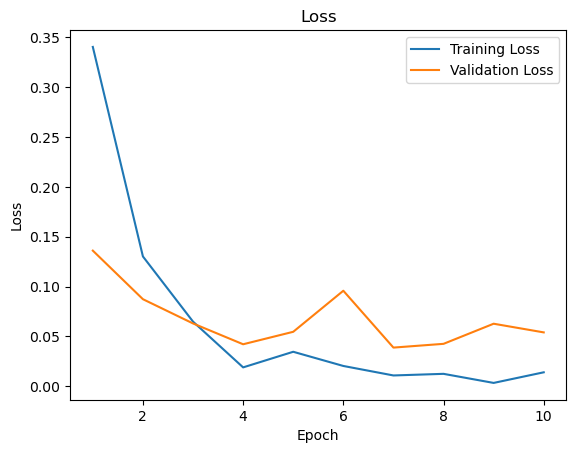

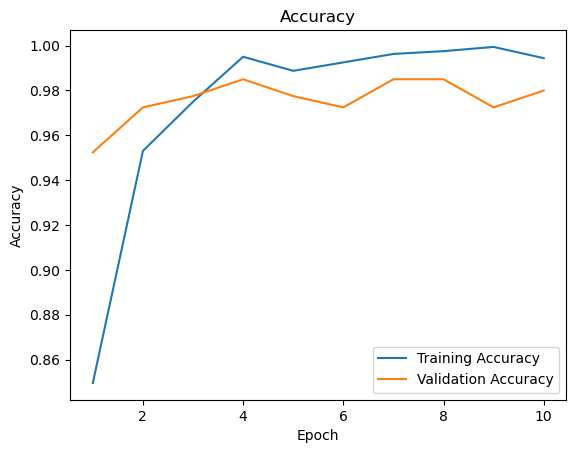

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9774    0.9630    0.9701       135
           1     0.9812    0.9886    0.9849       264

    accuracy                         0.9799       399
   macro avg     0.9793    0.9758    0.9775       399
weighted avg     0.9799    0.9799    0.9799       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

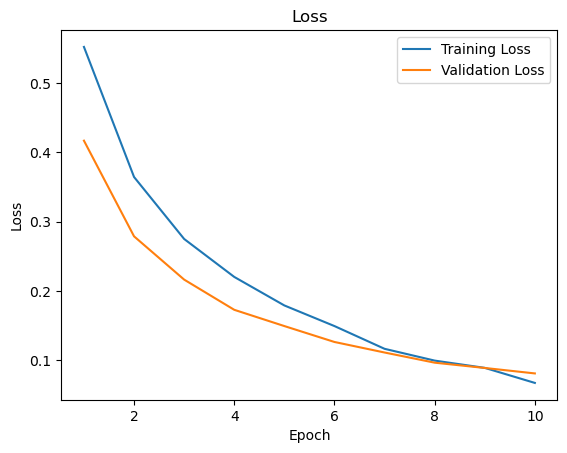

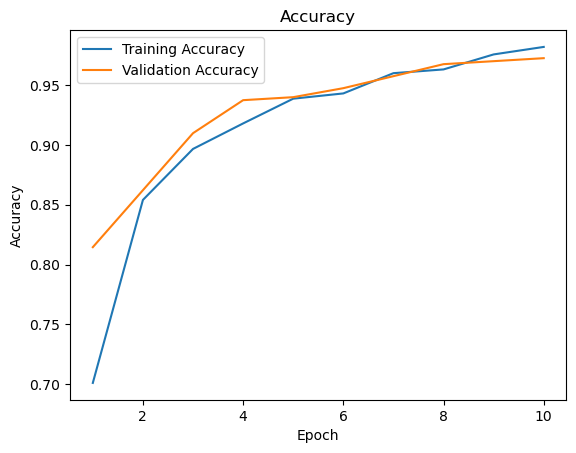

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9559    0.9630    0.9594       135
           1     0.9810    0.9773    0.9791       264

    accuracy                         0.9724       399
   macro avg     0.9684    0.9701    0.9693       399
weighted avg     0.9725    0.9724    0.9725       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

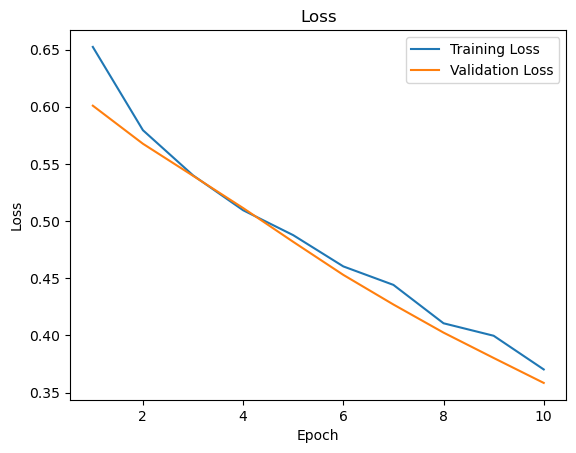

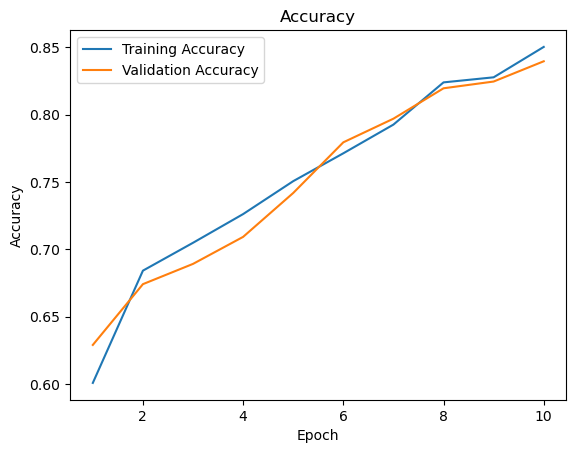

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9277    0.5704    0.7064       135
           1     0.8165    0.9773    0.8897       264

    accuracy                         0.8396       399
   macro avg     0.8721    0.7738    0.7980       399
weighted avg     0.8541    0.8396    0.8277       399



In [8]:
for lr in [1e-3, 1e-4, 1e-5]:
    exp[f'lr_{lr}'] = run_experiment(
        experiment_name=f'lr_{lr}',
        training={'learning_rate': lr},
        callbacks={"save_model": True},
    )

## Optimizer Variations
Different optimizers to assess optimization dynamics.


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                              SGD
training.loss                :              binary_crossentropy
training.metrics             :        

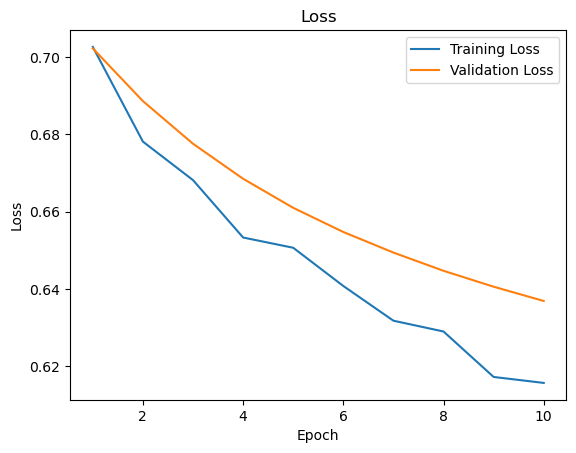

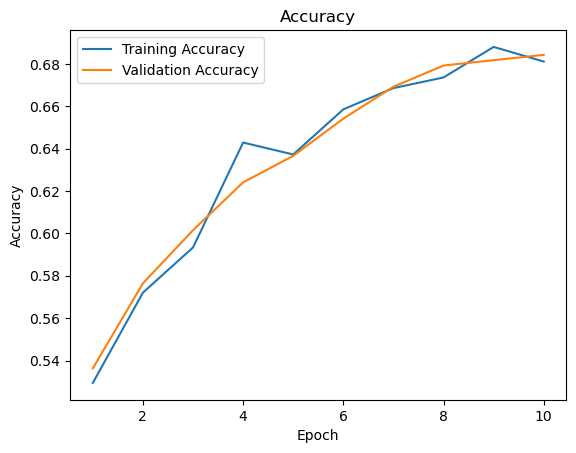

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.7368    0.1037    0.1818       135
           1     0.6816    0.9811    0.8043       264

    accuracy                         0.6842       399
   macro avg     0.7092    0.5424    0.4931       399
weighted avg     0.7003    0.6842    0.5937       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

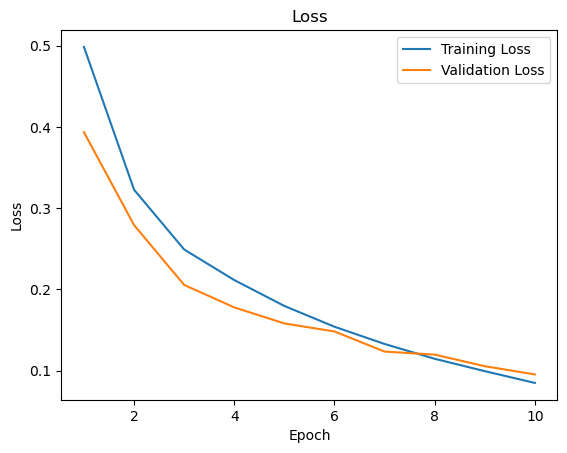

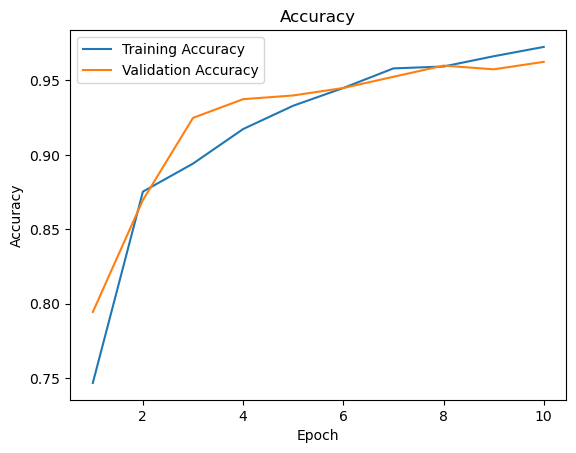

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9412    0.9481    0.9446       135
           1     0.9734    0.9697    0.9715       264

    accuracy                         0.9624       399
   macro avg     0.9573    0.9589    0.9581       399
weighted avg     0.9625    0.9624    0.9624       399



2025-05-16 14:42:47.159996: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                          Adagrad
training.loss                :              binary_crossentropy
training.metrics             :        

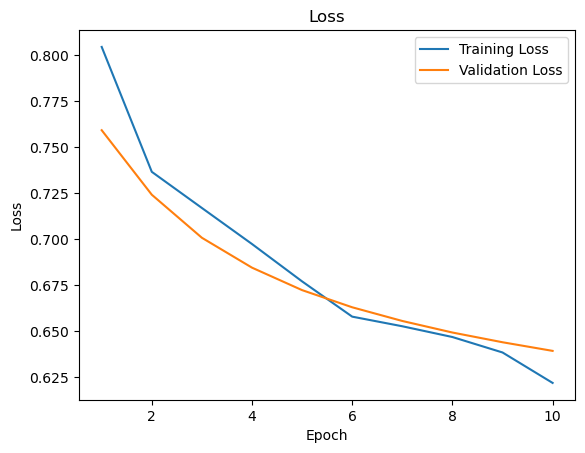

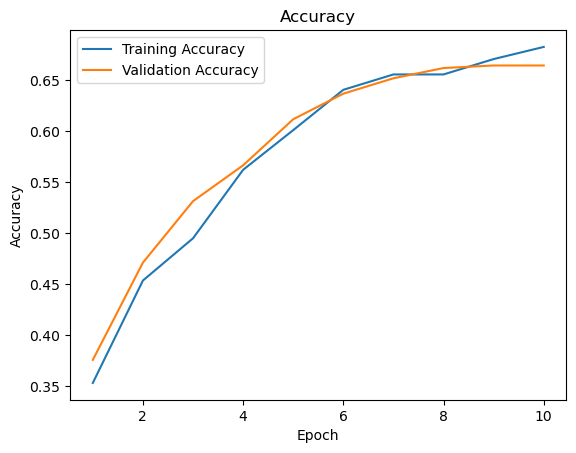

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.5556    0.0370    0.0694       135
           1     0.6667    0.9848    0.7951       264

    accuracy                         0.6642       399
   macro avg     0.6111    0.5109    0.4323       399
weighted avg     0.6291    0.6642    0.5496       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

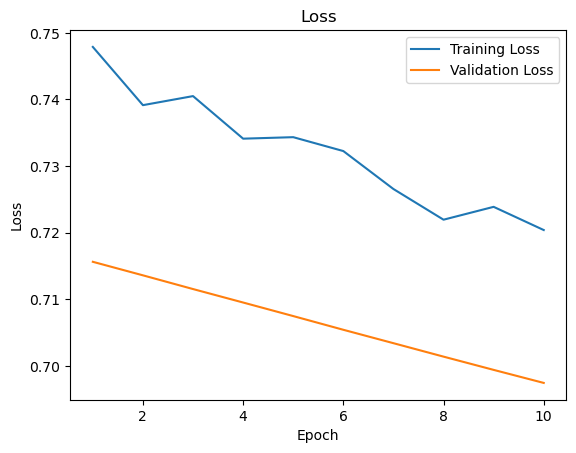

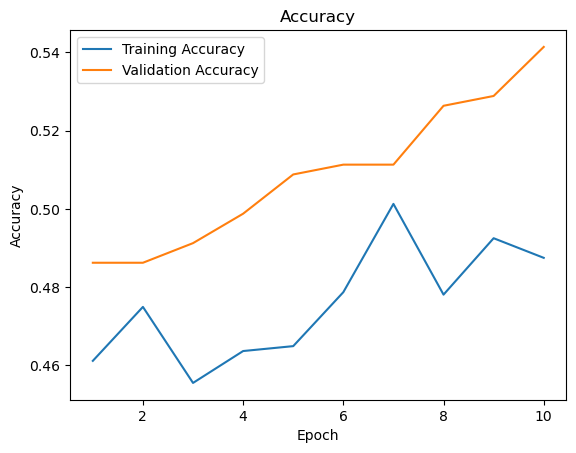

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.3879    0.6148    0.4756       135
           1     0.7189    0.5038    0.5924       264

    accuracy                         0.5414       399
   macro avg     0.5534    0.5593    0.5340       399
weighted avg     0.6069    0.5414    0.5529       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

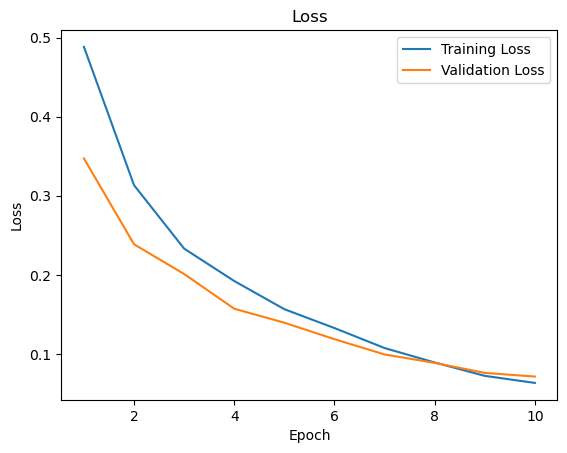

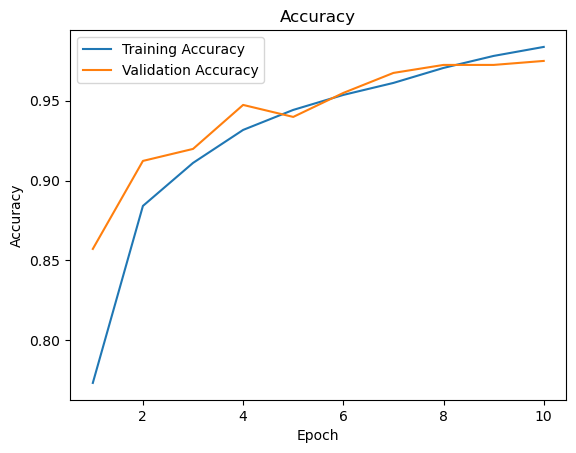

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9562    0.9704    0.9632       135
           1     0.9847    0.9773    0.9810       264

    accuracy                         0.9749       399
   macro avg     0.9705    0.9738    0.9721       399
weighted avg     0.9751    0.9749    0.9750       399



In [9]:
for opt in ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']:
    exp[f'optimizer_{opt}'] = run_experiment(
        experiment_name=f'optimizer_{opt}',
        training={'optimizer': opt},
        callbacks={"save_model": True},
    )

## Dropouts
To find the balance between robustness and capacity
- Lower rates: make training more stable but might under-regularize
- higher rates: inject more noise to prevent co-adaptation of filters and combat overfitting


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

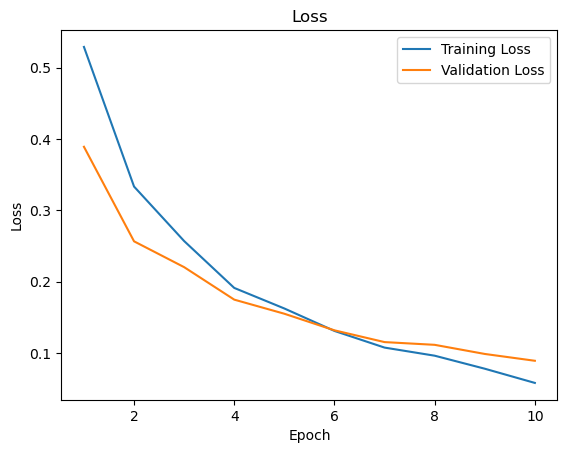

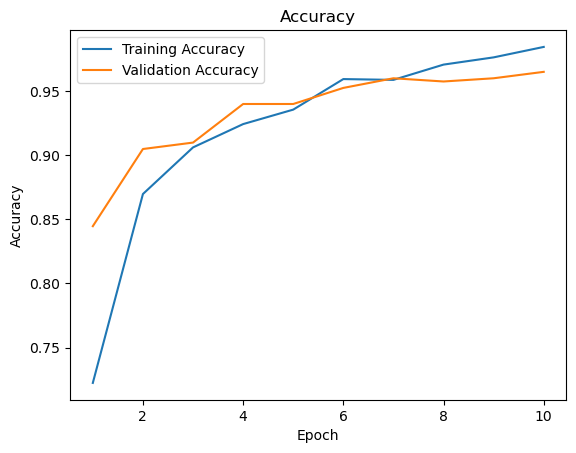

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9764    0.9185    0.9466       135
           1     0.9596    0.9886    0.9739       264

    accuracy                         0.9649       399
   macro avg     0.9680    0.9536    0.9602       399
weighted avg     0.9652    0.9649    0.9646       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

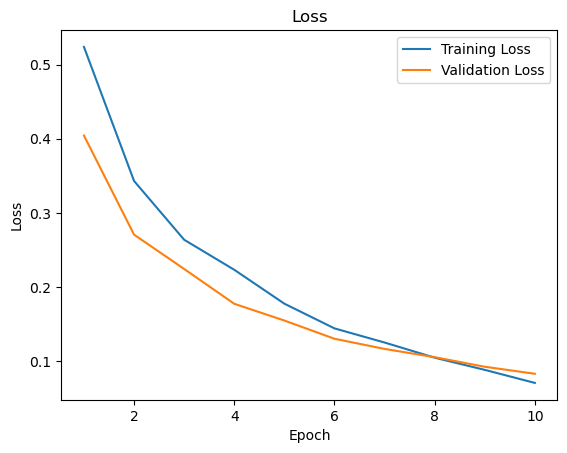

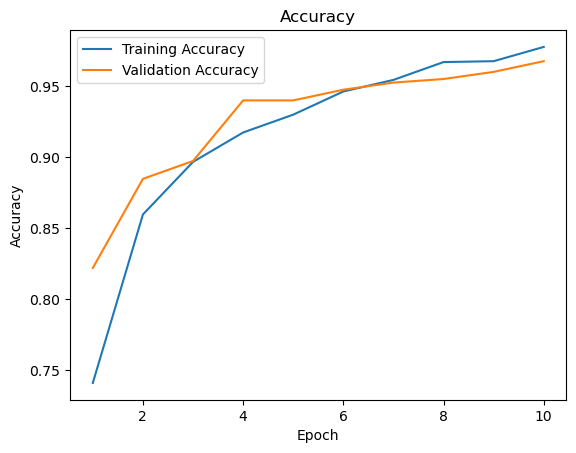

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9552    0.9481    0.9517       135
           1     0.9736    0.9773    0.9754       264

    accuracy                         0.9674       399
   macro avg     0.9644    0.9627    0.9635       399
weighted avg     0.9674    0.9674    0.9674       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

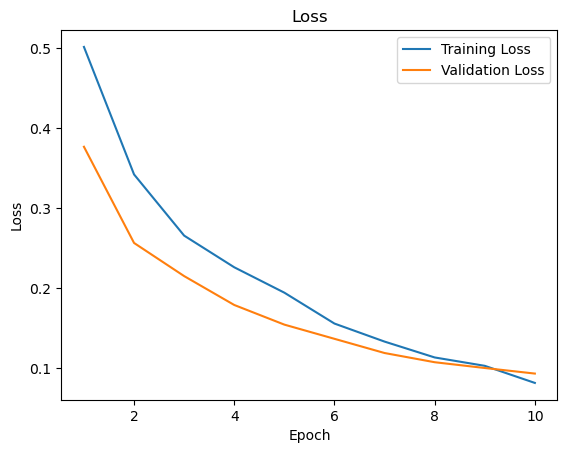

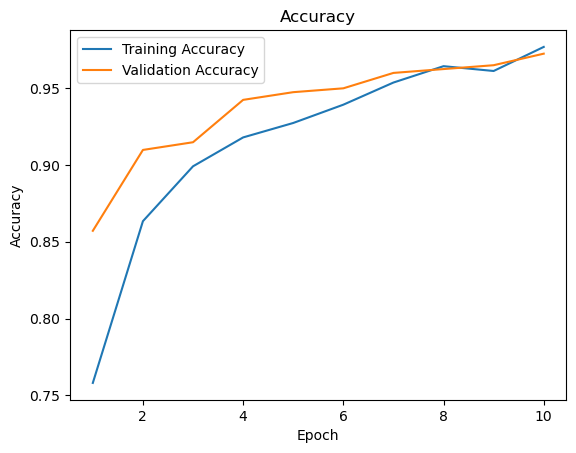

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9627    0.9556    0.9591       135
           1     0.9774    0.9811    0.9792       264

    accuracy                         0.9724       399
   macro avg     0.9700    0.9683    0.9692       399
weighted avg     0.9724    0.9724    0.9724       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

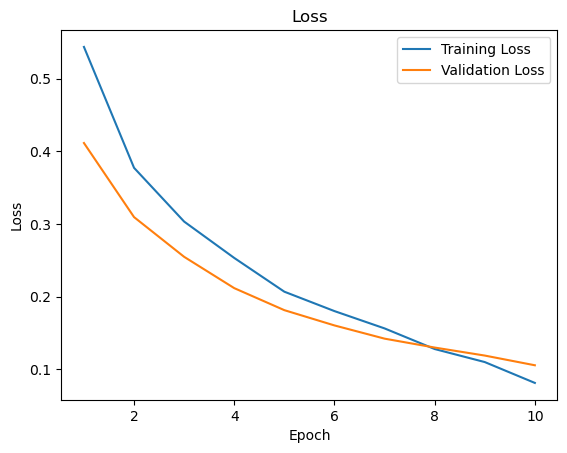

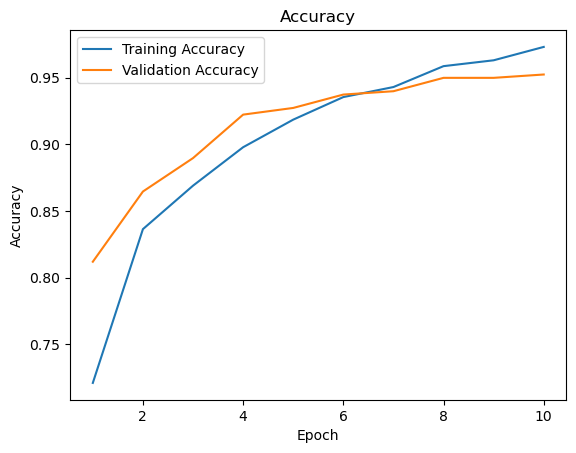

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 480ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9462    0.9111    0.9283       135
           1     0.9554    0.9735    0.9644       264

    accuracy                         0.9524       399
   macro avg     0.9508    0.9423    0.9463       399
weighted avg     0.9523    0.9524    0.9522       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

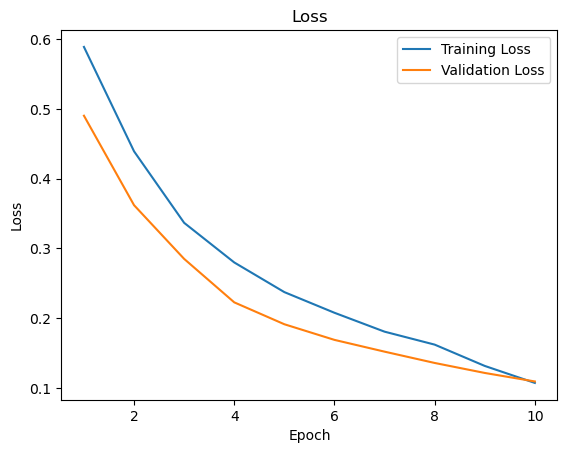

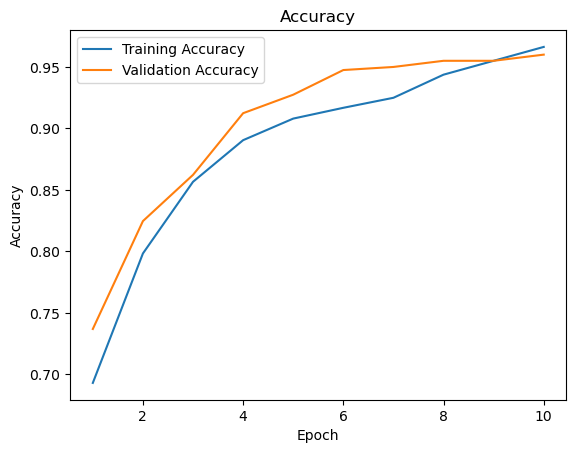

2025-05-16 14:50:52.441581: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9542    0.9259    0.9398       135
           1     0.9627    0.9773    0.9699       264

    accuracy                         0.9599       399
   macro avg     0.9584    0.9516    0.9549       399
weighted avg     0.9598    0.9599    0.9597       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

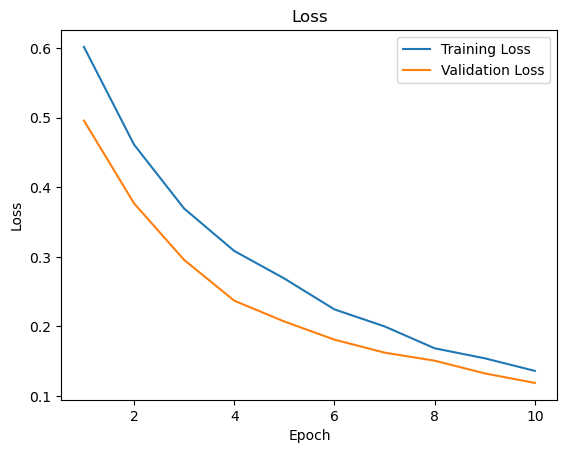

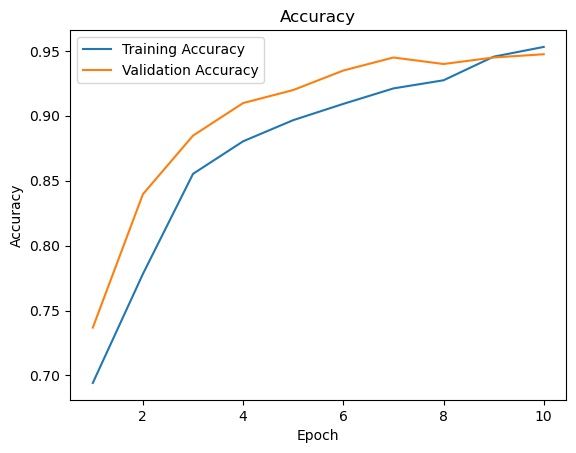

2025-05-16 14:51:53.568720: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9453    0.8963    0.9202       135
           1     0.9483    0.9735    0.9607       264

    accuracy                         0.9474       399
   macro avg     0.9468    0.9349    0.9404       399
weighted avg     0.9473    0.9474    0.9470       399



In [10]:
for dr in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    exp[f'dropout_{dr}'] = run_experiment(
        experiment_name=f'dropout_{dr}',
        model={'dropout_rate': dr},
        callbacks={"save_model": True},
    )

## Batch Size
Trade-off between gradient‐estimate noise and computational efficiency


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

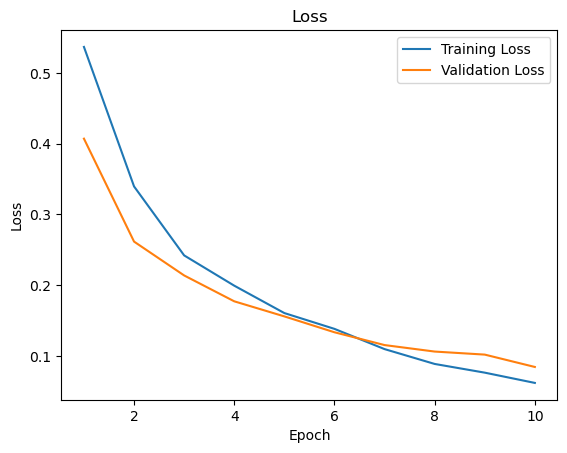

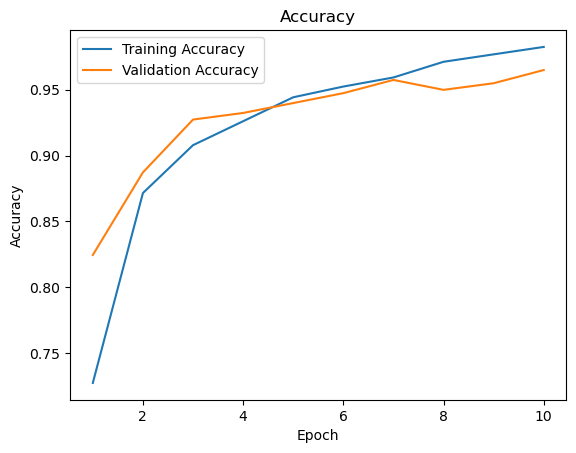

2025-05-16 14:52:54.231958: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9690    0.9259    0.9470       135
           1     0.9630    0.9848    0.9738       264

    accuracy                         0.9649       399
   macro avg     0.9660    0.9554    0.9604       399
weighted avg     0.9650    0.9649    0.9647       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               16
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

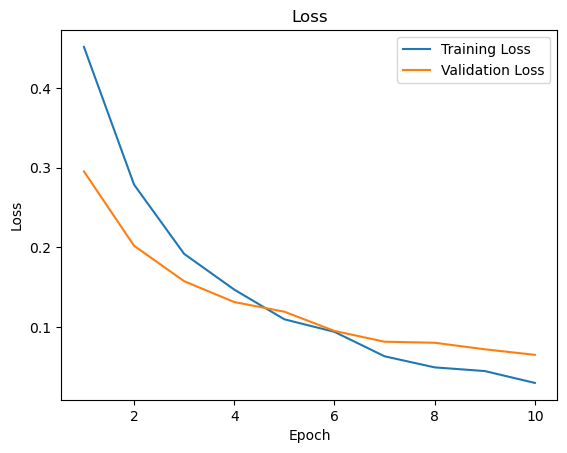

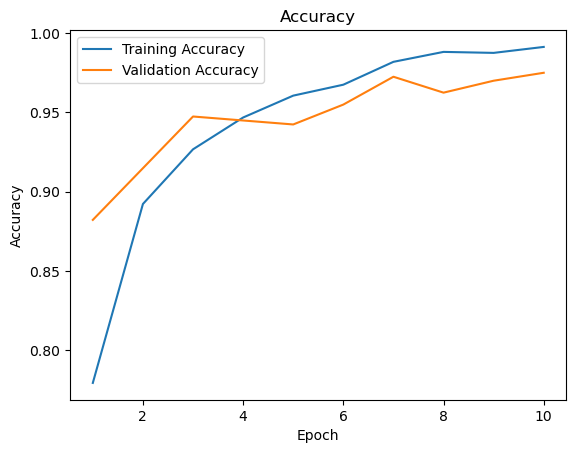

2025-05-16 14:54:05.440771: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9845    0.9407    0.9621       135
           1     0.9704    0.9924    0.9813       264

    accuracy                         0.9749       399
   macro avg     0.9774    0.9666    0.9717       399
weighted avg     0.9751    0.9749    0.9748       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                                8
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

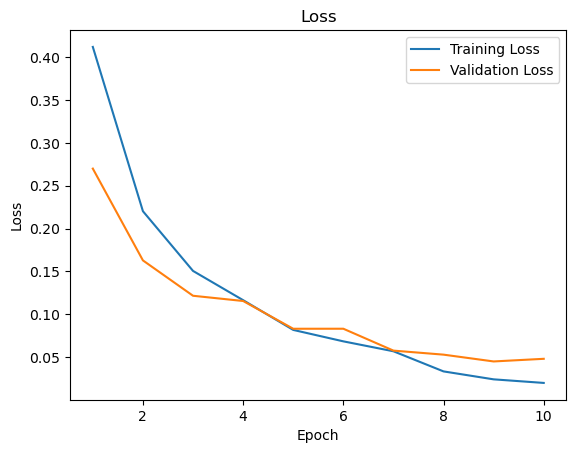

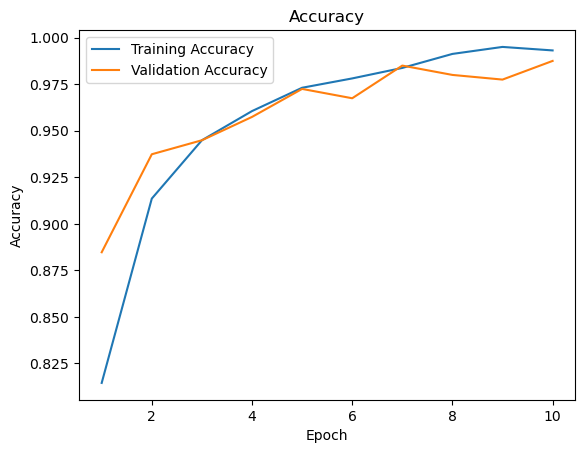

2025-05-16 14:55:24.309418: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9851    0.9778    0.9814       135
           1     0.9887    0.9924    0.9905       264

    accuracy                         0.9875       399
   macro avg     0.9869    0.9851    0.9860       399
weighted avg     0.9875    0.9875    0.9875       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                                4
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

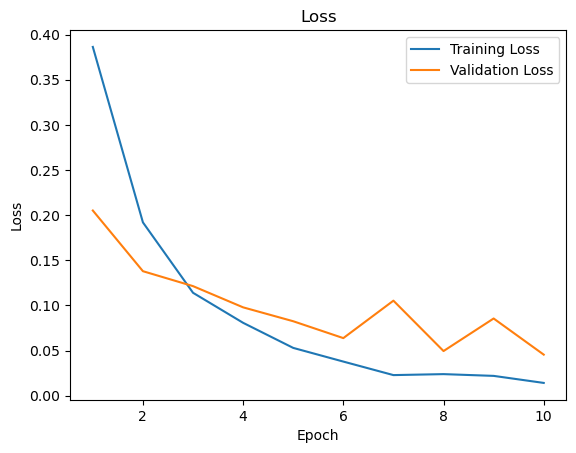

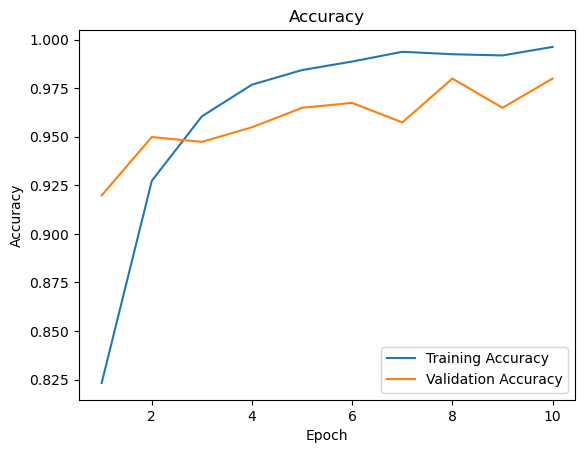

2025-05-16 14:56:52.023291: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9774    0.9630    0.9701       135
           1     0.9812    0.9886    0.9849       264

    accuracy                         0.9799       399
   macro avg     0.9793    0.9758    0.9775       399
weighted avg     0.9799    0.9799    0.9799       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                                2
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

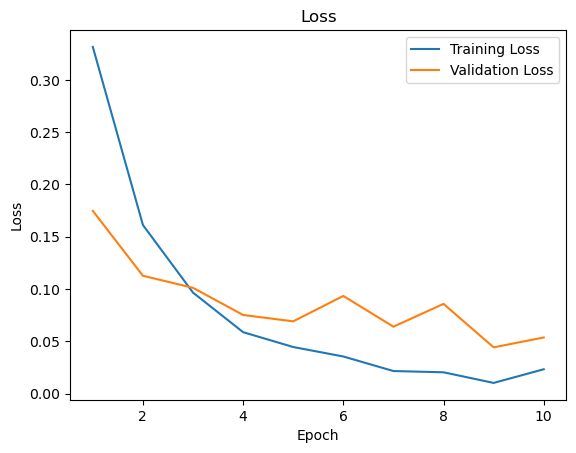

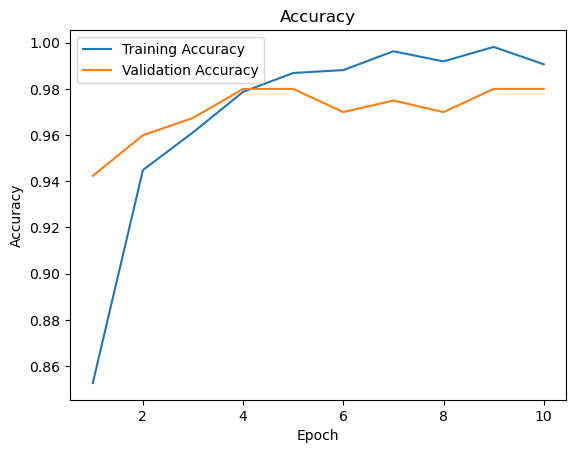

2025-05-16 14:58:52.248993: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9922    0.9481    0.9697       135
           1     0.9741    0.9962    0.9850       264

    accuracy                         0.9799       399
   macro avg     0.9832    0.9722    0.9774       399
weighted avg     0.9802    0.9799    0.9798       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                                1
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

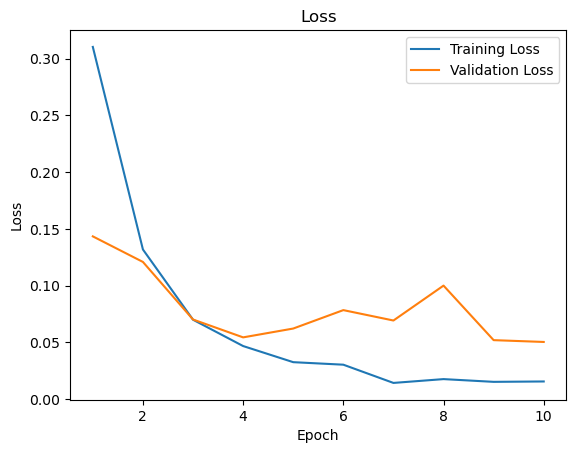

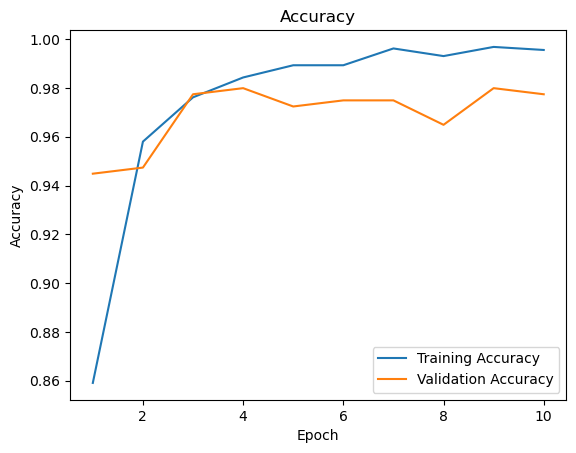

2025-05-16 15:02:09.004566: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9922    0.9407    0.9658       135
           1     0.9705    0.9962    0.9832       264

    accuracy                         0.9774       399
   macro avg     0.9813    0.9685    0.9745       399
weighted avg     0.9778    0.9774    0.9773       399



In [11]:
for bs in [32, 16, 8, 4, 2, 1]:
    exp[f"batchsize_{bs}"] = run_experiment(
        experiment_name=f"batchsize_{bs}",
        data={"batch_size": bs},
        callbacks={"save_model": True},
    )

## Results

In [33]:
report_experiments(exp, alpha=0.2)

,Experiment,Category,Validation Accuracy,Validation Loss,Overfit Gap,NormLoss,Score
0,mag_40,Magnification,0.9624,0.0839,0.0225,0.0000,0.9585
1,mag_100,Magnification,0.9447,0.1458,0.0410,0.7049,0.3424
2,mag_200,Magnification,0.9303,0.1718,0.0787,1.0000,0.0000
3,mag_400,Magnification,0.9286,0.1716,0.0079,0.9984,0.2013
4,baseline,Baseline,0.9749,0.0863,0.0243,0.0000,1.0000
5,block_6,Blocks,0.9950,0.0193,0.0122,0.1209,0.7618
6,block_5,Blocks,0.9950,0.0168,0.0047,0.0878,0.8244
7,block_4,Blocks,0.9975,0.0102,0.0018,0.0000,0.9086
8,block_3,Blocks,0.9900,0.0195,-0.0172,0.1231,0.9016
9,block_2,Blocks,0.9774,0.0506,0.0244,0.5326,0.3739


,Category,Experiment,Validation Accuracy,Validation Loss,Overfit Gap
0,Baseline,baseline,0.9749,0.0863,0.0243
1,Batch Sizes,batchsize_8,0.9774,0.0450,0.0209
2,Blocks,block_4,0.9975,0.0102,0.0018
3,Dropouts,dropout_0.3,0.9674,0.0833,0.0123
4,Learning Rate,lr_0.001,0.9850,0.0388,0.0279
5,Magnification,mag_40,0.9624,0.0839,0.0225
6,Optimizers,optimizer_Adam,0.9749,0.0713,0.0081
7,Other,best,0.7895,0.5438,-0.3622


## Best Model
Test to see if the best in each set of experiments will produce a better performance


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                                8
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                4
model.blocks_to_unfreeze     :                             None
model.dropout_rate           :                             0.30
training.epochs              :                               30
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

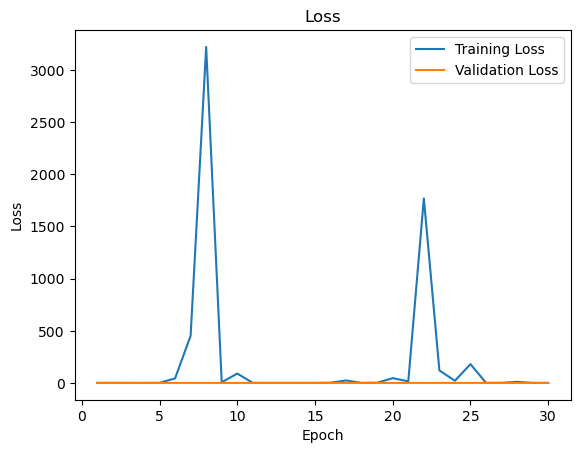

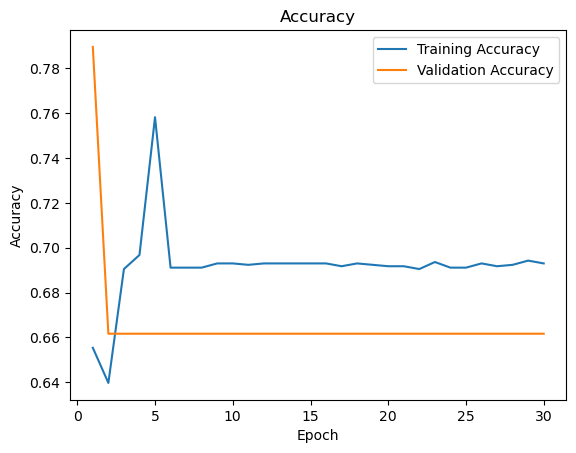

2025-05-16 15:34:34.118831: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 240244284 bytes after encountering the first element of size 240244284 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       135
           1     0.6617    1.0000    0.7964       264

    accuracy                         0.6617       399
   macro avg     0.3308    0.5000    0.3982       399
weighted avg     0.4378    0.6617    0.5269       399



/home/johnny/miniconda3/envs/machine-learning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/johnny/miniconda3/envs/machine-learning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/johnny/miniconda3/envs/machine-learning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [29]:
exp['best'] = run_experiment(
    experiment_name='best_model',
    data={
        'batch_size': 8,
        'data_dir': 'data/breakhis-dataset/binary/40X'
    },
    model={
        'unfreeze_blocks': 4,
        'dropout_rate': 0.3
    },
    training={
        'epochs': 30,
        'learning_rate': 1e-3,
        'optimizer': 'Adam'
    },
    callbacks={
        'save_model': True
    }
)

## Additional Experiments

In [4]:
add_experiments = {}


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                              [4]
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

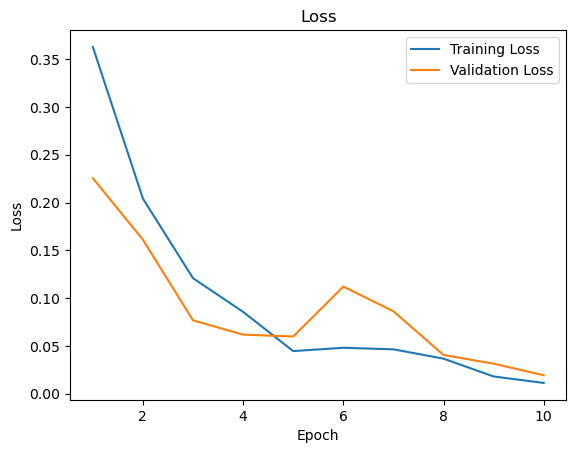

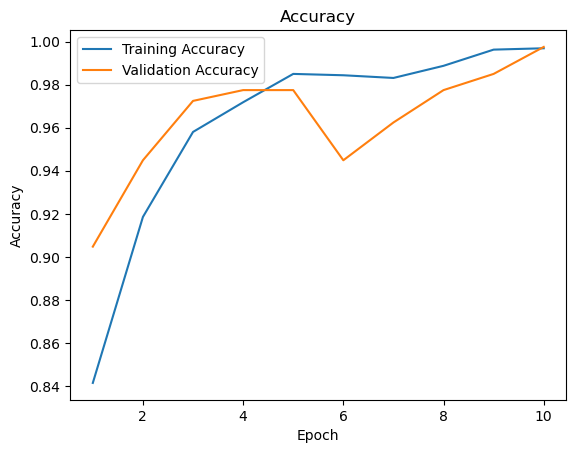

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9926    0.9963       135
           1     0.9962    1.0000    0.9981       264

    accuracy                         0.9975       399
   macro avg     0.9981    0.9963    0.9972       399
weighted avg     0.9975    0.9975    0.9975       399



2025-05-16 18:20:38.134174: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     :                              [4]
model.dropout_rate           :                             0.20
training.epochs              :                               10
training.learning_rate       :                             0.00
training.optimizer           :                             Adam
training.loss                :              binary_crossentropy
training.metrics             :        

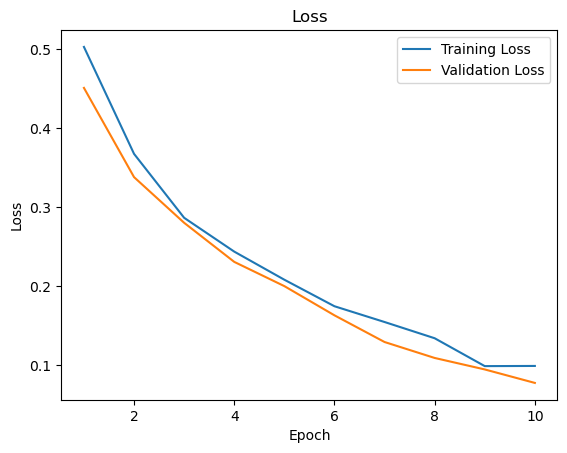

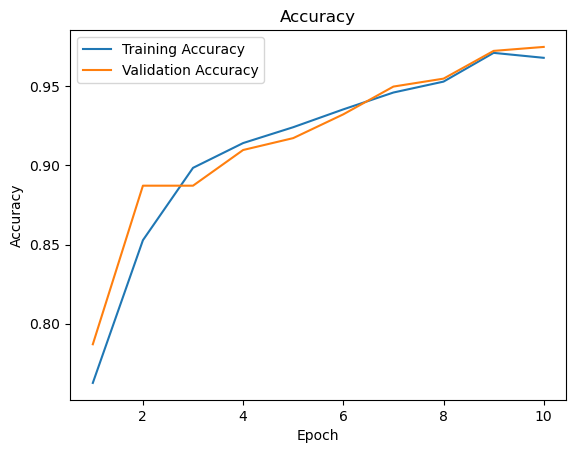

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9562    0.9704    0.9632       135
           1     0.9847    0.9773    0.9810       264

    accuracy                         0.9749       399
   macro avg     0.9705    0.9738    0.9721       399
weighted avg     0.9751    0.9749    0.9750       399


                       Experiment Config                        
data.data_dir                : data/breakhis-dataset/binary/40X
data.img_size                :                              224
data.batch_size              :                               32
data.validation_split        :                             0.20
data.seed                    :                              123
model.backbone               :                   EfficientNetB0
model.pretrained             :                             True
model.unfreeze_blocks        :                                1
model.blocks_to_unfreeze     

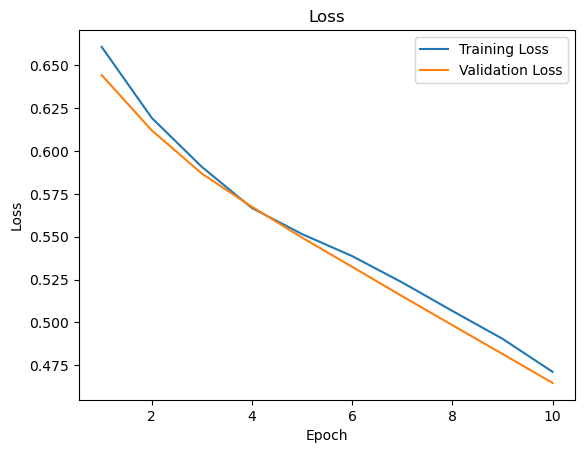

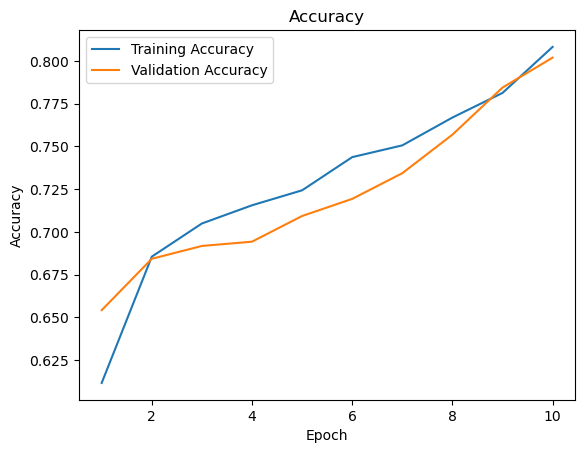

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9667    0.4296    0.5949       135
           1     0.7729    0.9924    0.8690       264

    accuracy                         0.8020       399
   macro avg     0.8698    0.7110    0.7319       399
weighted avg     0.8384    0.8020    0.7762       399



In [5]:
# Learning rates using block4
for lr in [1e-3, 1e-4, 1e-5]:
    add_experiments[f'lr_{lr}_block4'] = run_experiment(
        experiment_name=f'lr_{lr}_block4',
        training={'learning_rate': lr},
        callbacks={"save_model": True},
        model={"blocks_to_unfreeze": [4]}
    )

In [ ]:
report_experiments(add_experiments, alpha=0.2)